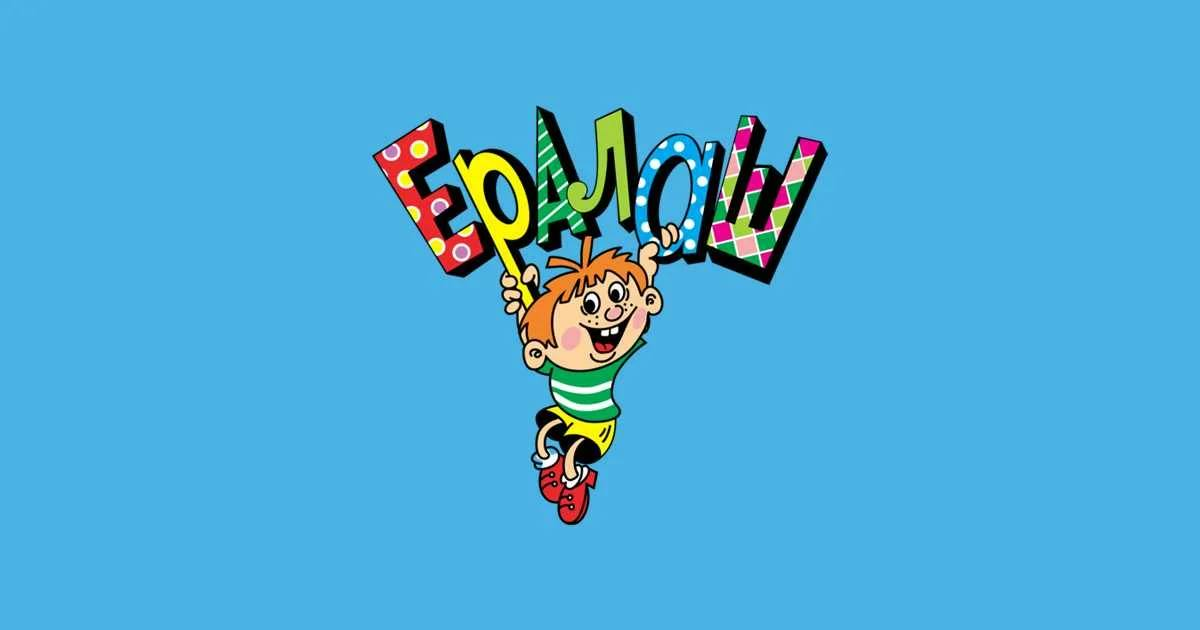

__Работу выполняли:__

Бригинский Макар - БЭК2110

Кузнецова Милена - БЭК2111

Михайлина Валерия - БЭК2111

## 1. Тема проекта

Целью нашего проекта является анализ рынка ежемесячной аренды квартир в Москве. Мы проанализируем, как влияют на стоимость аренды различные факторы: площадь, время до метро, а также техническое оснащение квартиры. Кроме того, мы выясним, какие квартиры предлагаются на рынке в зависимости от площади, количества комнат, этажа и бытовых приборов. 

## 2. Парсинг - сбор данных


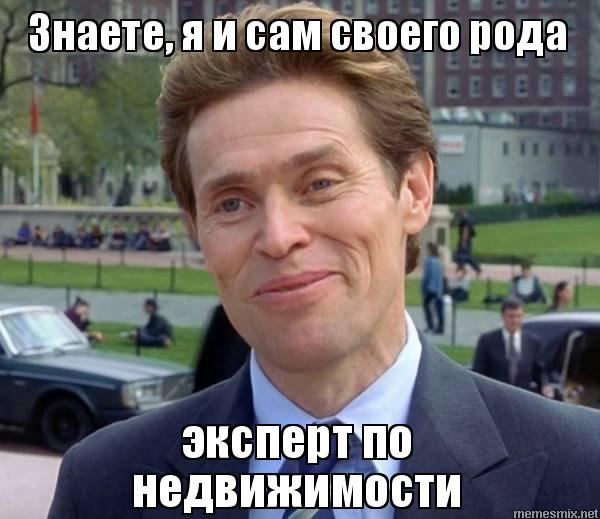

Мы спарсили сайт М2, а именно варианты квартир с ежемесячной арендой. 

Код для парсинга можно найти в файле _parsing.py._
Готовый датасет лежит в файле _result.csv._

На следующем этапе мы обработаем наш датасет: заполним пропуски, удалим строчки, где отсусутсвуют значимые для анализа переменные, а также закодируем категориальные признаки. 

## 3. Предварительная обработка

In [270]:
import pandas as pd
import numpy as np
df = pd.read_csv('result.csv')
df.head()

,href,title,price,zalog,predoplata,komissiyaarea,floor,totalArea,kitchenArea,livingArea,...,hasKitchenFurniture,hasTv,hasWashingMachine,hasBalcony,ceilingHeightM,routesList,windowsDirection,ceilingHeightM.1,index,komissiya
0,https://m2.ru/moskva/nedvizhimost/arenda-1-kom...,"Аренда 1-комнатной квартиры 33 м², 6/9 этаж",37000.0,37 000 ₽,37 000 ₽,NaN,6.0,33.000000,9.0,20 м²,...,True,False,True,True,"2,7","{""timeMinutes"":15,""transportType"":""FOOT"",""stat...",REAR,"2,7",1.0,владельцу 30%
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
2,https://m2.ru/moskva/nedvizhimost/arenda-1-kom...,"Аренда 1-комнатной квартиры 34,1 м², 9/12 этаж",37000.0,37 000 ₽,37 000 ₽,NaN,9.0,34.099998,9.6,14 м²,...,True,True,True,True,"2,65","{""timeMinutes"":22,""transportType"":""FOOT"",""stat...",FRONT,"2,65",3.0,NaN
3,https://m2.ru/moskva/nedvizhimost/arenda-1-kom...,"Аренда 1-комнатной квартиры 27 м², 2/5 этаж",33000.0,33 000 ₽,33 000 ₽,NaN,2.0,27.000000,5.0,17 м²,...,True,False,True,False,"2,5","{""timeMinutes"":9,""transportType"":""FOOT"",""stati...",REAR,"2,5",4.0,NaN
4,https://m2.ru/moskva/nedvizhimost/arenda-3-kom...,"Аренда 3-комнатной квартиры 69 м², 1/25 этаж",72000.0,72 000 ₽,72 000 ₽,NaN,1.0,69.000000,10.0,42 м²,...,True,False,True,True,"2,48","{""timeMinutes"":10,""transportType"":""FOOT"",""stat...",REAR,"2,48",5.0,NaN


Удаляем колонки и строки, которые не нужны для анализа: 

In [271]:
df = df.drop(index=[351,482, 483, 685, 788, 732, 1065, 1081]) #удаляем ненужные строки 
df = df.drop(columns=['href', 'komissiyaarea', 'index']) #удаляем ненужные колонки  
df = df.dropna(how='all') #удаляем строки, в которых отсутсвуют все значения 

In [272]:
df = df.reset_index(drop=True) #индексируем строки 

In [273]:
df['livingArea'] = df['livingArea'].replace(to_replace =[','], value = '.', regex = True) 

In [274]:
df[['zalog','predoplata','livingArea','routesList']] = df[['zalog','predoplata','livingArea','routesList']].replace(to_replace =['₽', 'м²','{"timeMinutes":',','], value = '', regex = True) #удаляем лишние символы из колонок 

Из колонки _'routesList'_ получаем значение минимального времени от дома до метро: 

In [275]:
df['timeMetro'] = 0
for i in range(1092):
    df['timeMetro'][i] = df['routesList'][i][:2]

/var/folders/dd/hdnynzdd6zzf1yw2l70ldwjc0000gn/T/ipykernel_51960/949337963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timeMetro'][i] = df['routesList'][i][:2]
/Users/mileshka/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Удаляем оставшиеся ненужные колонки: 

In [276]:
df = df.drop(columns = ['routesList','ceilingHeightM.1','komissiya','ceilingHeightM'])

In [277]:
df = df.replace(to_replace =['"'], value = '', regex = True)

Преобразовываем данные в колонках в числовые значения и заполняем пропуски: 

Пропуски в колонках с залогом и предоплатой заполняем 0, предполагая, что если отсутсвтует информация, значит, залог и предоплата при аренде не требуется. 

In [278]:
df['zalog'] = df['zalog'].str.replace('\xa0', '') 
df['zalog'] = df['zalog']. fillna (value= 0)
df['zalog'] = df['zalog'].astype(str).astype(int)
df['predoplata'] = df['predoplata'].str.replace('\xa0', '')
df['predoplata'] = df['predoplata'].fillna(value= 0)
df['predoplata'] = df['predoplata'].astype(str).astype(int)
df['timeMetro'] = df['timeMetro'].astype(str).astype(int)
df['livingArea'] = df['livingArea'].str.replace('\xa0', '')
df['livingArea'] = df['livingArea'].fillna(value= 0)
df['livingArea'] = df['livingArea'].astype(str).astype(float)

In [279]:
df[['hasAirConditioner','hasDishwasher', 'hasFridge','hasFurniture','hasInternet','hasKitchenFurniture','hasTv','hasWashingMachine','hasBalcony']] = df[['hasAirConditioner','hasDishwasher', 'hasFridge','hasFurniture','hasInternet','hasKitchenFurniture','hasTv','hasWashingMachine','hasBalcony']].fillna(value= False)

Кодируем категориальные данные: 

In [280]:
df.loc[df["hasAirConditioner"] == False, "hasAirConditioner"] = 0 #0 - нет кондиционера
df.loc[df["hasAirConditioner"] == True, "hasAirConditioner"] = 1 #1 - есть кондиционер
df.loc[df["hasDishwasher"] == False, "hasDishwasher"] = 0 #0 - нет посудомоечной машины
df.loc[df["hasDishwasher"] == True, "hasDishwasher"] = 1 #1 - есть посудомоечная машина 
df.loc[df["hasFridge"] == False, "hasFridge"] = 0 #0 - нет холодильника
df.loc[df["hasFridge"] == True, "hasFridge"] = 1  #1 - есть холодильник 
df.loc[df["hasFurniture"] == False, "hasFurniture"] = 0 #0 - нет мебели
df.loc[df["hasFurniture"] == True, "hasFurniture"] = 1 #1 - есть мебель 
df.loc[df["hasInternet"] == False, "hasInternet"] = 0 #0 - нет интернета 
df.loc[df["hasInternet"] == True, "hasInternet"] = 1 #0 - есть интернет 
df.loc[df["hasKitchenFurniture"] == False, "hasKitchenFurniture"] = 0 #0 - нет кухонной мебели 
df.loc[df["hasKitchenFurniture"] == True, "hasKitchenFurniture"] = 1 #1 - есть кухонная мебель 
df.loc[df["hasTv"] == False, "hasTv"] = 0 #0 - нет телевизора 
df.loc[df["hasTv"] == True, "hasTv"] = 1 #1 - есть телевизор 
df.loc[df["hasWashingMachine"] == False, "hasWashingMachine"] = 0 #0 - нет стиральной машины 
df.loc[df["hasWashingMachine"] == True, "hasWashingMachine"] = 1 #1 - есть стиральная машина 
df.loc[df["hasBalcony"] == False, "hasBalcony"] = 0 #0 - нет балкона 
df.loc[df["hasBalcony"] == True, "hasBalcony"] = 1 #1 - есть балкон 

df['windowsDirection'] = df['windowsDirection'].fillna(0)
df.loc[df['windowsDirection'] == 'FRONT', "windowsDirection"] = 0 #0 - вид на улицу 
df.loc[df['windowsDirection'] == 'REAR', "windowsDirection"] = 1 #1 - вид во двор 
df.loc[df['windowsDirection'] == 'BOTH', "windowsDirection"] = 2 #2 - вид на улицу и во двор 

In [281]:
df[['hasAirConditioner','hasDishwasher', 'hasFridge','hasFurniture','hasInternet','hasKitchenFurniture','hasTv','hasWashingMachine','hasBalcony','windowsDirection']] = df[['hasAirConditioner','hasDishwasher', 'hasFridge','hasFurniture','hasInternet','hasKitchenFurniture','hasTv','hasWashingMachine','hasBalcony','windowsDirection']].astype(int)

Из названия объявлений получаем количество этажей в доме: 

In [282]:
df['floorsHouse'] = 0
for i in range(1092):
    df['floorsHouse'][i] = df['title'][i][-7:]

/var/folders/dd/hdnynzdd6zzf1yw2l70ldwjc0000gn/T/ipykernel_51960/2330346318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['floorsHouse'][i] = df['title'][i][-7:]


In [283]:
df['floorsHouse'] = df['floorsHouse'].replace(to_replace =['/', ' ','этаж'], value = '', regex = True)

In [284]:
df['floorsHouse'] = df['floorsHouse'].astype(str).astype(int)

In [285]:
df['roomsCount'] = df['roomsCount']. fillna (value= 1)

Готовый датасет после обработки: 

In [286]:
df.head()

,title,price,zalog,predoplata,floor,totalArea,kitchenArea,livingArea,roomsCount,hasAirConditioner,...,hasFridge,hasFurniture,hasInternet,hasKitchenFurniture,hasTv,hasWashingMachine,hasBalcony,windowsDirection,timeMetro,floorsHouse
0,"Аренда 1-комнатной квартиры 33 м², 6/9 этаж",37000.0,37000,37000,6.0,33.000000,9.0,20.0,1.0,0,...,1,1,0,1,0,1,1,1,15,9
1,"Аренда 1-комнатной квартиры 34,1 м², 9/12 этаж",37000.0,37000,37000,9.0,34.099998,9.6,14.0,1.0,0,...,1,1,1,1,1,1,1,0,22,12
2,"Аренда 1-комнатной квартиры 27 м², 2/5 этаж",33000.0,33000,33000,2.0,27.000000,5.0,17.0,1.0,0,...,1,1,0,1,0,1,0,1,9,5
3,"Аренда 3-комнатной квартиры 69 м², 1/25 этаж",72000.0,72000,72000,1.0,69.000000,10.0,42.0,3.0,0,...,1,1,1,1,0,1,1,1,10,25
4,"Аренда 2-комнатной квартиры 54 м², 3/16 этаж",50000.0,50000,50000,3.0,54.000000,9.0,32.0,2.0,1,...,1,1,1,1,1,1,1,1,16,16


После обработки данных каждая строчка набора данных содержит следующие поля:

- title - название объявления

- price - стоимость аренды в месяц

- zalog - величина залога

- predoplata - величины предоплаты

- floor - этаж

- totalArea - общая площадь квартиры

- kitchenArea - площадь кухни

- livingArea - жилая площадь

- roomsCount - количество комнат

- hasAirConditioner - наличие кондиционера (1 - если есть, 0 - если нет) 

- hasDishwasher - наличие посудомоечной машины (1 - если есть, 0 - если нет)

- hasFridge - наличие холодильника (1 - если есть, 0 - если нет)

- hasFurniture - наличие мебели (1 - если есть, 0 - если нет)

- hasInternet - наличие интернета (1 - если есть, 0 - если нет)

- hasKitchenFurniture - наличие кухонной мебели (1 - если есть, 0 - если нет)

- hasTv - наличие телевизора (1 - если есть, 0 - если нет)

- hasWashingMachine - наличие стиральной машины (1 - если есть, 0 - если нет)

- hasBalcony - наличие балкона (1 - если есть, 0 - если нет)

- windowsDirection - вид из окна (2 - во двор и на улицу, 1 - во двор, 0 - на улицу) 

- timeMetro - время до ближайшего метро 

- floorsHouse - количество этажей в доме 

## 4. Визуализация и создание новых признаков

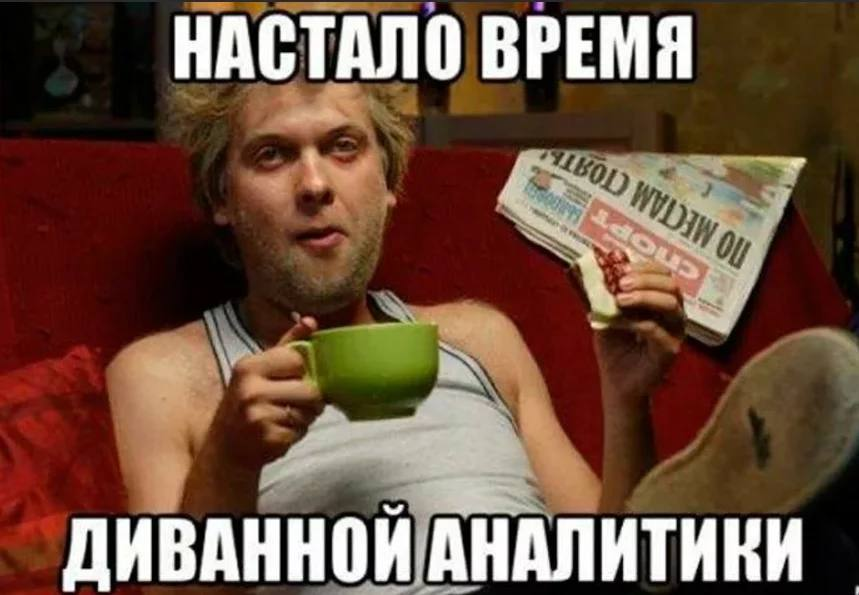

__Чтобы понять, как связаны наши переменные с ценой аренды, построим матрицу корреляций:__

In [287]:
import matplotlib.pyplot as plt
import seaborn as sns

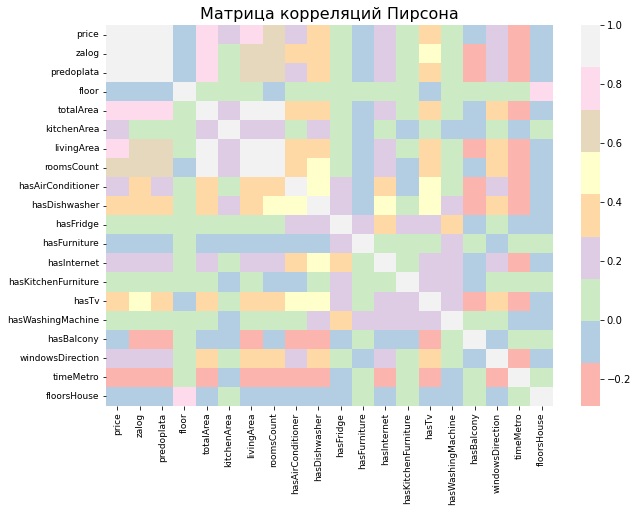

In [288]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, cmap="Pastel1")
plt.xticks(size=9)
plt.yticks(size=9)

plt.title('Матрица корреляций Пирсона', fontsize= 16);

In [289]:
corr = corr_matrix['price'].to_frame (name='values')
corr

,values
price,1.000000
zalog,0.923862
predoplata,0.933622
floor,-0.010957
totalArea,0.764844
kitchenArea,0.150740
livingArea,0.726756
roomsCount,0.617194
hasAirConditioner,0.208603
hasDishwasher,0.340275


На основе корреляций можно сделать довольно логичные выводы о том, что размер залога и предоплата сильно связаны с ценой (так как чем выше цена, тем больше размер залога и предоплаты). Такой же вывод можно сделать о площади и количестве комнат, поскольку чем больше площадь квартиры, тем выше цена. Мы видим наличие отрицательной корреляции цены и времени до метро, значит, чем меньше времени занимает путь до метро, тем выше стоимость, но значение корреляции по модулю не очень большое, так как могут влиять другие факторы, например, станция метро и район. 

Если говорить о других переменных (техническом оснащении квартиры), то мы наблюдаем низкую корреляцию и не можем утверждать о наличии взаимосвязи с ценой, то есть при выборе квариры скорее всего эти факторы не являются решающими. 

__Рассмотрим, на каких этажах чаще всего сдают квартиры:__

In [290]:
x = df['floor']
y = df['floorsHouse']

/Users/mileshka/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


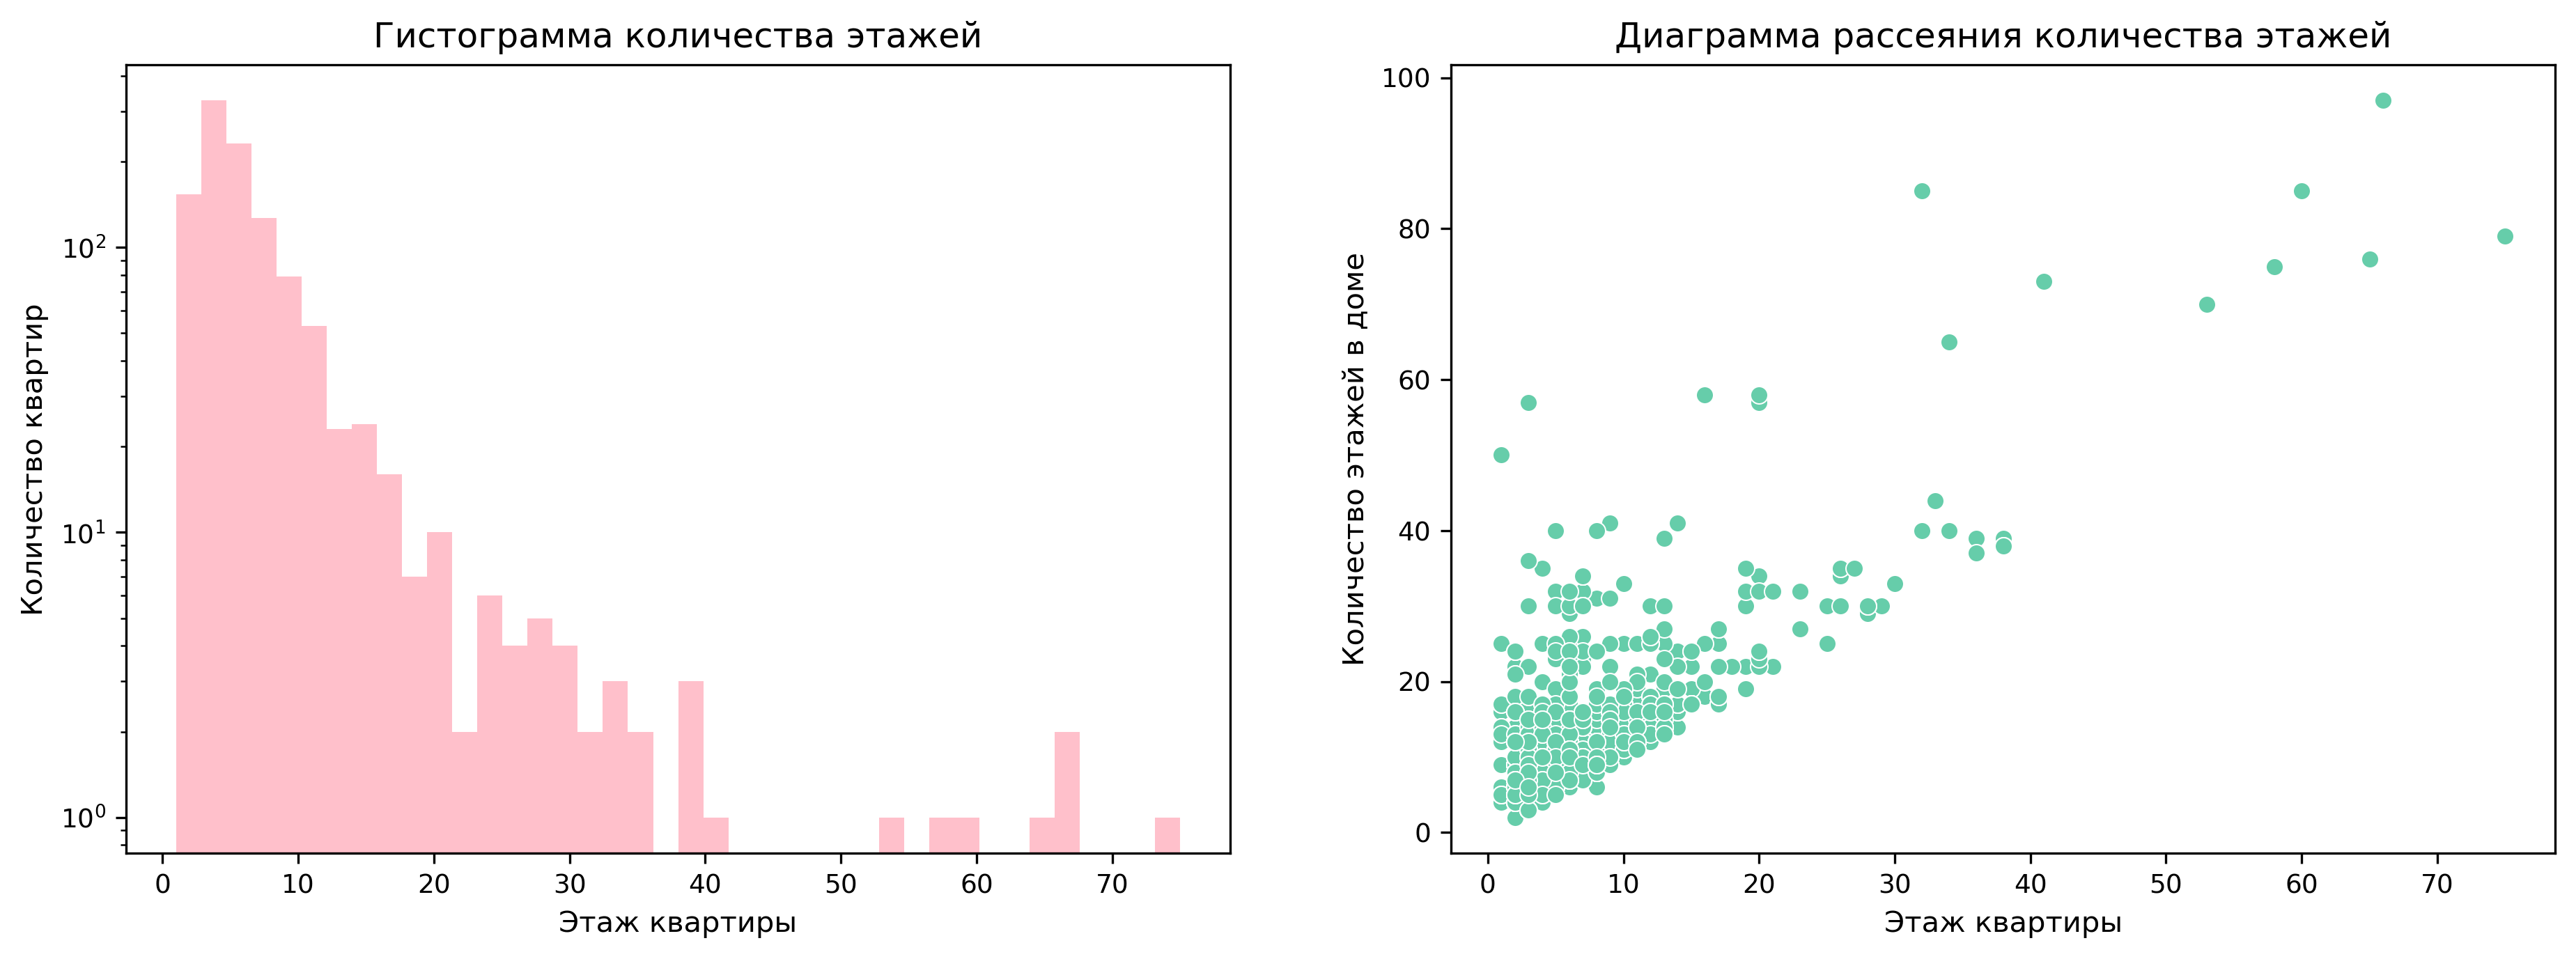

In [291]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5), dpi=300)

plt.subplot(1, 2, 1)
plt.hist(x, bins=40, log=True, color = 'pink')
plt.xlabel("Этаж квартиры", fontsize=10)
plt.ylabel("Количество квартир", fontsize=10)
plt.xticks(size=9)
plt.yticks(size=9)
plt.title('Гистограмма количества этажей', fontsize=12)

plt.subplot(1, 2, 2)
sns.scatterplot(x, y, color = 'mediumaquamarine')
plt.xticks(size=9)
plt.yticks(size=9)
plt.xlabel("Этаж квартиры", fontsize=10)
plt.ylabel("Количество этажей в доме", fontsize=10)
plt.title('Диаграмма рассеяния количества этажей', fontsize=12)

plt.show()

По данным гистограммы количества этажей можно увидеть, что больше всего сдаются квартиры на 1 - 10 этажах. В глобальном плане количество квартир до 15-го этажа в разы превосходит количество квартир выше 15-го. Можем наблюдать несколько выбросов: сдается несколько квартир на 50-х, 60-х и даже 70-х этажах.

На диаграмме рассеяния мы видим, что больше всего домов с менее, чем 20 этажами. На графике присутствует множество выбросов. Мы не можем определить точную закономерность на каком этаже будет сдана квартира, зная количество этажей в доме.

__Рассмотрим, как распределяются доли в зависимости от количества комнат в квартире__

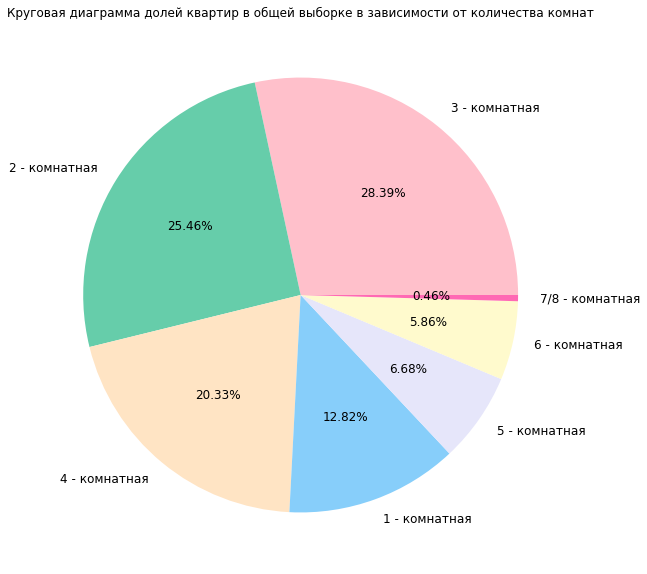

In [292]:
x = df['roomsCount'].value_counts()
x[7.0] = x[7.0] + x[8.0]
colors = ['pink', 'mediumaquamarine', 'bisque','lightskyblue', 'lavender','lemonchiffon', 'hotpink']

x = x.drop(8.0)
labels = ['3 - комнатная',
          '2 - комнатная',
          '4 - комнатная',
          '1 - комнатная',
          '5 - комнатная',
          '6 - комнатная',
          '7/8 - комнатная']
plt.figure(figsize=(15, 10))
plt.title('Круговая диаграмма долей квартир в общей выборке в зависимости от количества комнат')
plt.pie(x,labels=labels, textprops = {'fontsize': 12}, autopct='%1.2f%%', colors=colors);

На данной диаграмме мы видим, что 2-3-4 комнатные квартиры составляют 74.18% от всей выборки. Остальную четверть занимают квартиры с 1, 5-8 комнатами.
Чаще всего встречаются 3-х комнатные квартиры: 28.39%. Реже всего 7-8 комнатные: 0.46% от всей выборки. 

__Рассмотрим, как распределена стоимость квартир в зависимости от количества комнат__

Проанализируем квартиры с 1,2,3 комнатами: 

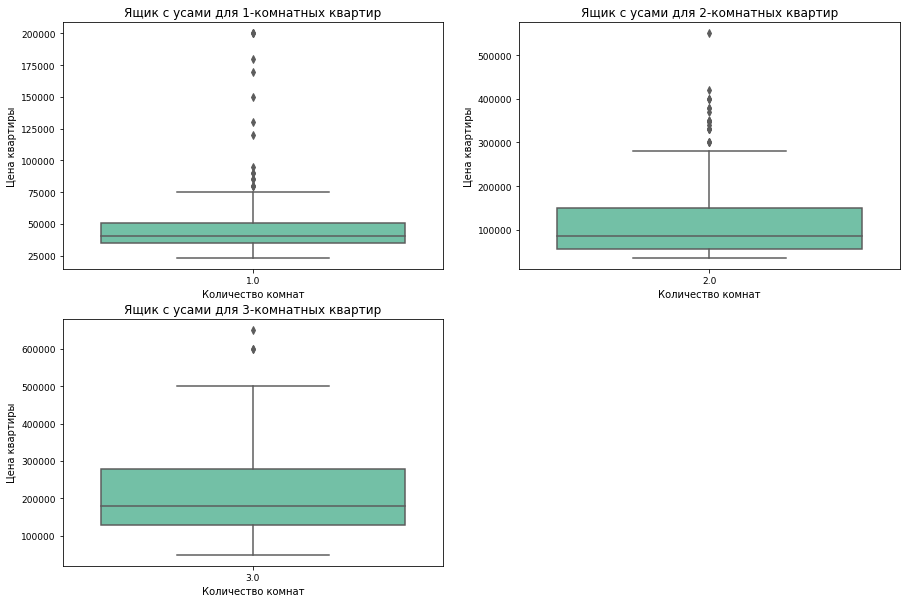

In [293]:
plt.figure(figsize=(15, 10))
x1=df[df['roomsCount'] == 1]
x2=df[df['roomsCount'] == 2] 
x3=df[df['roomsCount'] == 3]

plt.subplot(2, 2, 1)

sns.boxplot(x = x1['roomsCount'], y=x1['price'],color='mediumaquamarine')
plt.xlabel("Количество комнат", fontsize=10)
plt.ylabel("Цена квартиры", fontsize=10)
plt.xticks(size=9)
plt.yticks(size=9)
plt.title('Ящик с усами для 1-комнатных квартир', fontsize=12)

plt.subplot(2, 2, 2)
sns.boxplot(x = x2['roomsCount'], y=x2['price'],color='mediumaquamarine')
plt.xlabel("Количество комнат", fontsize=10)
plt.ylabel("Цена квартиры", fontsize=10)
plt.xticks(size=9)
plt.yticks(size=9)
plt.title('Ящик с усами для 2-комнатных квартир', fontsize=12)


plt.subplot(2, 2, 3)
sns.boxplot(x = x3['roomsCount'], y=x3['price'],color='mediumaquamarine')
plt.xlabel("Количество комнат", fontsize=10)
plt.ylabel("Цена квартиры", fontsize=10)
plt.xticks(size=9)
plt.yticks(size=9)
plt.title('Ящик с усами для 3-комнатных квартир', fontsize=12);

В результате визуализации несложно заметить, что в двух- и трехкомнатных квартирах разброс цен значительно больше, чем  в однокомнатных. Такой же вывод можно сделать о максимальной и минимальной ценах. Выбросы присутствуют во всех категориях, однако в квартирах с 2 и 3 комнатами выбросы над максимальной ценой распределены почти сплошной линией, а значит, таких объявлений достаточно много. 

__Рассмотрим взаимосвязь общей площади и стоимости квартир:__ 

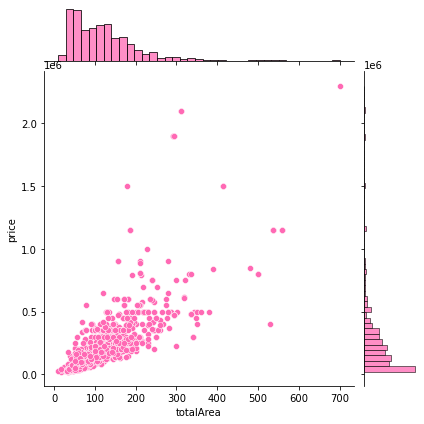

In [294]:
sns.jointplot(x='totalArea', y="price", data=df, color='hotpink');

Судя по гистограммам можно сделать вывод, что моды общей площади - 50 и 120 квадратных метров, а моды стоимости - около 100 и 300 тысяч в месяц. На диаграмме рассяния видно, что цена на квартиры чаще не превышвет 600 тысяч/месяц, а площадь квартир - обычно не больше 300 кв.м. Также на диаграмме заметна положительная взаимосвязь ежемесячной стоимости и общей площади квартиры. 

__Рассмотрим, как зависит наличие балкона от вида из окон квартиры__

In [295]:
balcony = df[df['hasBalcony'] == 1]['windowsDirection']

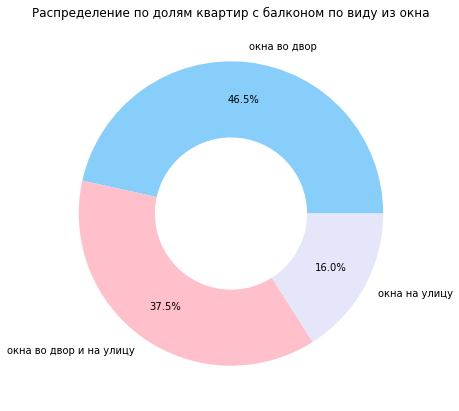

In [296]:
labels = ['окна во двор', 'окна во двор и на улицу', 'окна на улицу']
 
colors = ['lightskyblue','pink', 'lavender' ,'bisque','lemonchiffon', 'lightsalmon']

plt.figure(figsize=(10, 7))
plt.pie(balcony.value_counts(), colors=colors, labels=labels,
        autopct='%1.1f%%', pctdistance=0.75)
 
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()
 
fig.gca().add_artist(centre_circle)

plt.title('Распределение по долям квартир с балконом по виду из окна');

На основе построенного графика можно сделать вывод о том, что в квартирах с балконом преобладает вид во двор.

__Проанализируем, как влияет количество технических приборов в квартире на стоимость ее аренды:__

Создадим новую колонку _'AppliancesCount'_, в которой посчитаем общее количество удобств, которые находятся в квартире. 


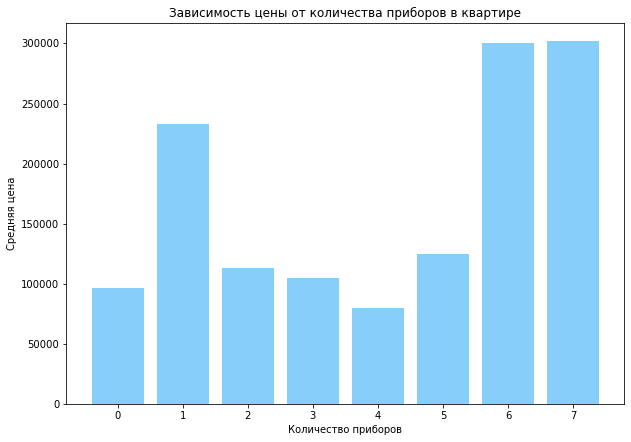

In [297]:
appliances_columns = ['hasAirConditioner', 'hasDishwasher', 'hasFridge', 'hasInternet', 'hasKitchenFurniture',
                      'hasTv', 'hasWashingMachine']

df['AppliancesCount'] = df[appliances_columns].sum(axis=1)

grouped_data = df.groupby('AppliancesCount')['price'].mean()
plt.figure(figsize=(10, 7))
plt.bar(grouped_data.index, grouped_data.values, color = 'lightskyblue')
plt.xlabel('Количество приборов')
plt.ylabel('Средняя цена')
plt.title('Зависимость цены от количества приборов в квартире')
plt.show()

Количество приборов в доме влияет на цену квартир. Особенно это заметно при наличии 6-7 приборов, так как стоимость аренды в месяц за такие квартиры достигает 300000 рублей. Квартиры со средним количеством удобств (2-4) колеблются в одном ценовом диапозоне. 

Также мы можем наблюдать выброс, где при наличии лишь 1 прибора цена достигает почти 250000. Скорее всего это связано с наличием экстремального значения стоимости квартиры или же на стоимость таких квартир влияет не только наличие удобств. 

__Рассмотрим, как распределяются доли в зависимости от количества бытовых приборов в квартире__ 

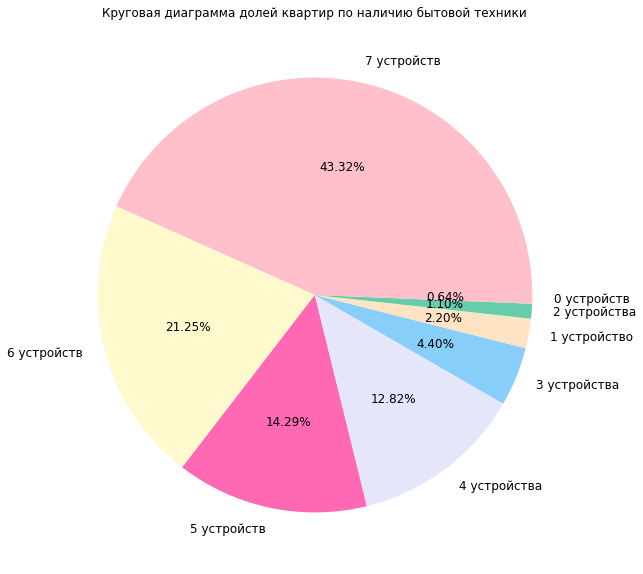

In [298]:
x = df['AppliancesCount'].value_counts()

labels = ['7 устройств',
          '6 устройств',
          '5 устройств',
          '4 устройства',
          '3 устройства',
          '1 устройство',
          '2 устройства',
          '0 устройств']
colors = ['pink','lemonchiffon','hotpink','lavender','lightskyblue', 'bisque',  'mediumaquamarine']

plt.figure(figsize=(15, 10))
plt.title('Круговая диаграмма долей квартир по наличию бытовой техники')
plt.pie(x,labels=labels, textprops = {'fontsize': 12}, autopct='%1.2f%%', colors = colors);

По круговой диаграмме видно, что более 60% квартир оснащены всеми необходимыми устройствами (6 и более), также практически отсутствуют квартиры без технического оснащения. Отсюда мы можем сделать вывод, что на рынке котируются квартиры с бытовой техникой. 

__Рассмотрим, какую долю занимает жилая площадь от площади всей квартиры__ 

Для того, чтобы проанализировать, какую долю занимает жилая площадь от площади всей квартиры создадим новый признак _'UtilizationCoefficient'_

In [299]:
df['UtilizationCoefficient'] = (df['livingArea']) / df['totalArea']
df[df['UtilizationCoefficient'] > 1] = 1

Визуализируем, как связано количество комнат и доля жилой и общей площади квартиры: 

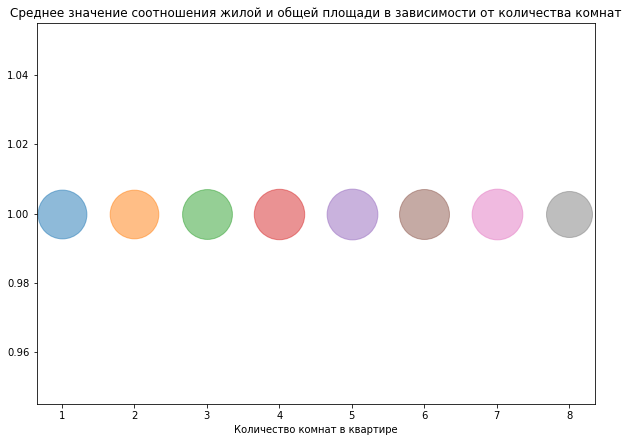

In [300]:
sizes = df.groupby('roomsCount').agg('mean')['UtilizationCoefficient']
sizes = sizes.to_dict()

plt.figure(figsize=(10, 7))
for i,y in enumerate(sizes.keys()):
    plt.scatter(i+1, 1, alpha=0.5, s = sizes[y]*4000)
plt.xlabel('Количество комнат в квартире')  
plt.title('Среднее значение соотношения жилой и общей площади в зависимости от количества комнат');

Мы видим, что в среднем жилая площадь занимает примерно одинаковую долю во всей квартире вне зависимости от количества комнат. Однако стоит заметить, что в квартирах с 8 комнатами эта доля чуть меньше. 

__Рассмотрим, как распределена стоимость первого месяца аренды квартиры в зависимости от количества комнат__

Чтобы произвести анализ, создадим колонку _'firstMonth'_, в которой просуммируем залог, предоплату и месячную аренду. 

In [301]:
df['firstMonth'] = df['price'] + df['zalog'] + df['predoplata']

In [302]:
df_new = df.groupby('roomsCount').mean()['firstMonth'].to_frame (name='mean_value')

Визуализируем, как связаны стоимость первого месяца аренды и количество комнат в квартире:

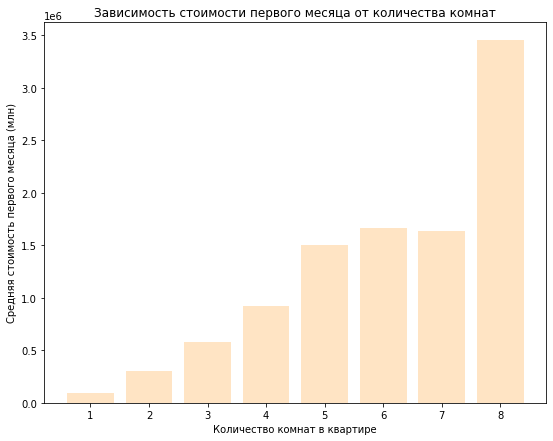

In [303]:
plt.figure(figsize=(9, 7))
plt.bar(df_new.index, df_new.mean_value, color = 'bisque')
plt.xlabel('Количество комнат в квартире')
plt.ylabel('Средняя стоимость первого месяца (млн)')
plt.title('Зависимость стоимости первого месяца от количества комнат')
plt.show()

В целом распределение квартир по стоимости аренды первого месяца и по количеству комнат получилось довольно логичным: чем больше комнат,тем дороже будет снять квартиру. 

## 5. Гипотезы 

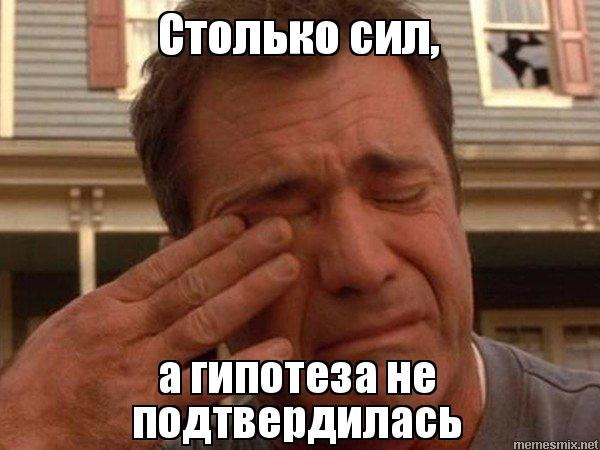

При помощи математической статистики проанализируем закономерности, которые мы выявили в процессе визуализации данных. 

Для проверки гипотез пример уровень значимости 5%

__1) Проверим гипотезу о том, что в среднем квартиры из выборки содержат 6 бытовых приборов__

$$
\begin{aligned}
&H_0: \hspace{2mm} \mu = 6 \hspace{2mm} \\
&H_1: \hspace{2mm} \mu < 6  \hspace{2mm} 
\end{aligned}
$$

In [304]:
from scipy import stats

Определим, подчиняется ли выборка нормальному распределению 

In [305]:
_, pvalue = stats.shapiro(df['AppliancesCount'])

alpha = 0.05

pvalue

3.941572607438771e-34

Поскольку p-value в тесте Шапиро-Уилка меньше 0.05(альфа), можно сделать вывод о том, что выборка имеет ненормальное распределение. 

In [306]:
from scipy.stats import wilcoxon
x = df['AppliancesCount'] - 6  
stat, p_value = wilcoxon(x)
alpha = 0.05

if p_value > alpha: 
    print('Гипотеза не отвергается')
else:
    print('Гипотеза отвергается')

Гипотеза отвергается


Так как гипотеза отвергается, делаем вывод о том, что в среднем в квартирах, сдаваемых в аренду, находится менее 6 бытовых приборов. 

__2) Проверим гипотезу о равенстве дисперсий цен на аренду двух- и трехкомнатных квартир__

$$
\begin{aligned}
&H_0: \hspace{2mm} \sigma^2_2 = \sigma^2_3 \hspace{2mm} \\
&H_1: \hspace{2mm} \sigma^2_2 \neq \sigma^2_3 \hspace{2mm} \\
\end{aligned}
$$

Поскольку нам неизвестно распределение цен, воспользуемся непараметрическим критерием Флигнера-Киллина о равенстве дисперсий 

In [307]:
from scipy.stats import fligner

x1=df[df['roomsCount'] == 2] 
x2=df[df['roomsCount'] == 3]

stat, p_value = fligner(x1['price'], x2['price'])

if p_value > alpha: 
    print('Гипотеза не отвергается')
else:
    print('Гипотеза отвергается')

Гипотеза отвергается


Так как гипотеза отвергается, делаем вывод о том, что дисперсии цен на двух- и трехкомнатные квартиры не равны. А значит, разброс цен в этих подвыборках отличается, что в целом видно и по ящику с усами (в разделе визуализаций). 

__3) Проверим гипотезу о равенстве дисперсий этажности домов и этажей, на которых расположены квартиры__

Поскольку нам неизвестно распределение этажности, воспользуемся непараметрическим критерием Флигнера-Киллина о равенстве дисперсий

$$
\begin{aligned}
&H_0: \hspace{2mm} \sigma^2_{дом} = \sigma^2_{квартира} \hspace{2mm} \\
&H_1: \hspace{2mm} \sigma^2_{дом} \neq \sigma^2_{квартира} \hspace{2mm} \\
\end{aligned}
$$

In [308]:
stat, p_value = fligner(df['floor'], df['floorsHouse'])

if p_value > alpha: 
    print('Гипотеза не отвергается')
else:
    print('Гипотеза отвергается')

Гипотеза отвергается


Так как гипотеза отвергается, делаем вывод о том, что разброс этажности домов и этажей квартир, сдаваемых в аренду, разный. Отсюда мы понимаем, что на рынке представлено меньше квартир либо нижних, либо верхних этажей, таким образом этажи распределены неравномерно и разброс значений оказывается меньше.

__4) Проверим гипотезу о том, что стоимость первого месяца равна трем ежемесячным платежам__

$$
\begin{aligned}
&H_0: \hspace{2mm} \mu_{первый} = 3* \mu_{ежемес} \hspace{2mm} \\
&H_1: \hspace{2mm} \mu_{первый} < 3* \mu_{ежемес}  \hspace{2mm} 
\end{aligned}
$$

Поскольку нам неизвестно распределение цен, воспользуемся непараметрическим критерием Уилкоксона для не независимых выборок 

In [309]:
stat, p_value = wilcoxon(df['firstMonth'], 3*df['price'], alternative ='less')
alpha = 0.05

if p_value > alpha: 
    print('Гипотеза не отвергается')
else:
    print('Гипотеза отвергается')

Гипотеза отвергается


Так как гипотеза отвегается, делаем вывод о том, что стоимость первого месяца неравна трем ежемесячным платежам за арендуемую квартиру. Соответственно, скорее всего есть квартиры, для аренды которых залог или предоплата ниже суммы ежемесячного платежа или они равны нулю. 

__5) Проверим гипотезу о том, что в квартирах с балконом вид из окна чаще выходит во двор__ 

$$
\begin{aligned}
&H_0: \hspace{2mm} p_1 > p_2 \hspace{2mm} \text{(В квартирах с балконом вид чаще выходит во двор)} \\
&H_1: \hspace{2mm} p_1 < p_2  \hspace{2mm} \text{(В квартирах с балконом вид чаще выходит на улицу)}
\end{aligned}
$$

In [310]:
view = df[df['hasBalcony'] == 1]['windowsDirection']
a =(view == 1).sum()
b = (view == 0).sum()
l1 = len(view)

In [311]:
from statsmodels.stats.proportion import proportions_ztest

In [312]:
stat, p_value = proportions_ztest([a, b], l1, alternative='smaller')
alpha = 0.05
if p_value > alpha: 
    print('Гипотеза не отвергается')
else:
    print('Гипотеза отвергается')

Гипотеза не отвергается


Поскольку гипотеза не отвергается, делаем вывод о том, что в квартирах с балконом вид чаще выходит во двор, нежели на улицу. 

## 5. Машинное обучение 

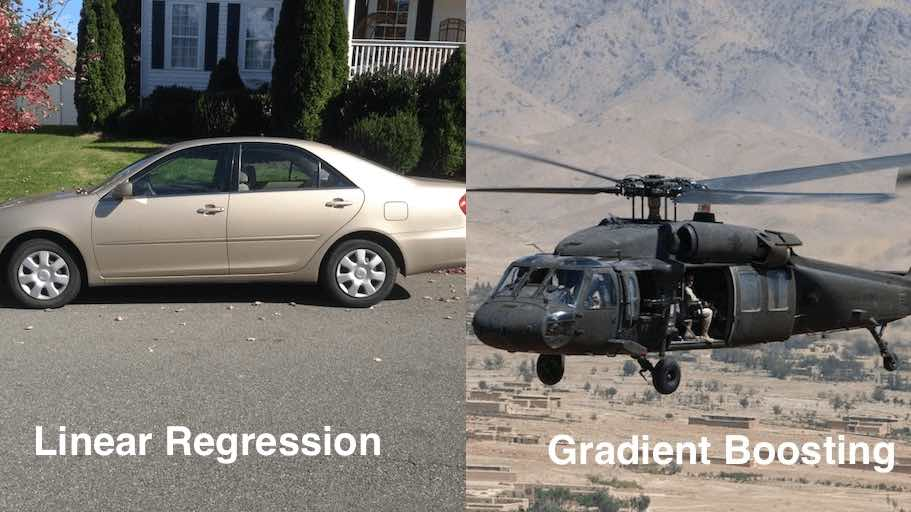

В даном разделе мы обучим модель, которая будет предсказывать стоимость квартиры по признакам из нашего датасета. 

In [313]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.linear_model import Lasso 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

__1) Линейная регрессия__ 

Сначала построим линейную регрессию для предсказания ежемесячной стоимости, используя в том числе данные о величине залога и предоплаты.

In [314]:
np.random.seed(17)

X = df.drop(columns=["price", 'title', 'firstMonth']).copy()
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_transformed, y_train)
y_pred = lr.predict(X_test_transformed)

mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

r2 = r2_score(y_test, y_pred)
print("R2:", r2)

MSE: 2204704341.131187
MAE: 30609.780519425392
R2: 0.9241535439811621


Если смотреть на коэффициент детерминации, то он получился достаточно выскоим, а значит, модель хорошо предсказывает цену. Это связано с тем, что есть признаки, который равны ежемесячной стоимости (залог и предоплата). 

Поскольку в большинстве случаев стоимость аренды равна злогу/предоплате, мы решили построить линейную регрессию, исключив эти параметры из выборки. 

In [315]:
np.random.seed(17)

X = df.drop(columns=["price", 'title', 'zalog', 'predoplata', 'firstMonth']).copy()
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

lr = LinearRegression() 
lr.fit(X_train_transformed, y_train)
y_pred = lr.predict(X_test_transformed)

mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

r2 = r2_score(y_test, y_pred)
print("R2:", r2)

MSE: 9935968932.020195
MAE: 71369.01713097512
R2: 0.6581818176035574


Можем заметить, что качество модели ухудшилось. 

In [316]:
lr.coef_

array([-13130.16529235, 281858.81603724,  -2689.91263537, -40662.34614837,
       -48770.60402163, -33034.65503244,  21966.50990939,  -5495.04526063,
         6487.35178821,  -7964.8740614 ,  10618.70561496,   8408.53105872,
         -795.09005028,  -3559.52085216, -14896.26068756,  -6354.1886942 ,
         -687.76082794,  16370.90948204,  17723.78204943])

В модели очень высокие коэффициенты. 

Далее добавим регуляризацю, которая будет штрафовать модель за высокие коэффициенты.

In [317]:
np.random.seed(17)

X = df.drop(columns=["price", 'title', 'zalog', 'predoplata', 'firstMonth']).copy()
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

lasso = Lasso(alpha = 10000) 
lasso.fit(X_train_transformed, y_train)
y_pred = lasso.predict(X_test_transformed)

mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

r2 = r2_score(y_test, y_pred)
print("R2:", r2)

MSE: 9165199043.362448
MAE: 66796.5743937391
R2: 0.6846979192731035


Можно заметить, что с регуляризацией модель стала показывать более хорошее качество, но оно все равно далекое от идеального. 

__2) Градиентный бустинг__ 

Попробуем обучить модель градиентного бустинга. Возможно она позволит добиться высокого качества. 

In [318]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

Запустим перебор по сетке, чтобы найти наилучшие параметры: 

In [319]:
np.random.seed(17)

X = df.drop(columns=["price", 'title', 'zalog', 'predoplata']).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 4, 5, 7, 9],
    'min_samples_split': [2, 3, 4,5]}
grid_search = GridSearchCV(GradientBoostingRegressor(), param_grid, scoring ='r2',cv=5)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 300}


In [320]:
gb = GradientBoostingRegressor(learning_rate =0.1, max_depth = 3, min_samples_split = 2, n_estimators = 300)

gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)
r2 = r2_score(y_test, y_pred)
print("R2:", r2)

MSE: 892545325.5995768
MAE: 12937.284174661414
R2: 0.9692945677477217


Мы видим, что градиентный бустинг позволил нам достичь лучшего качества, чем линейная регрессия. Это значит, что он является более эффективным. 

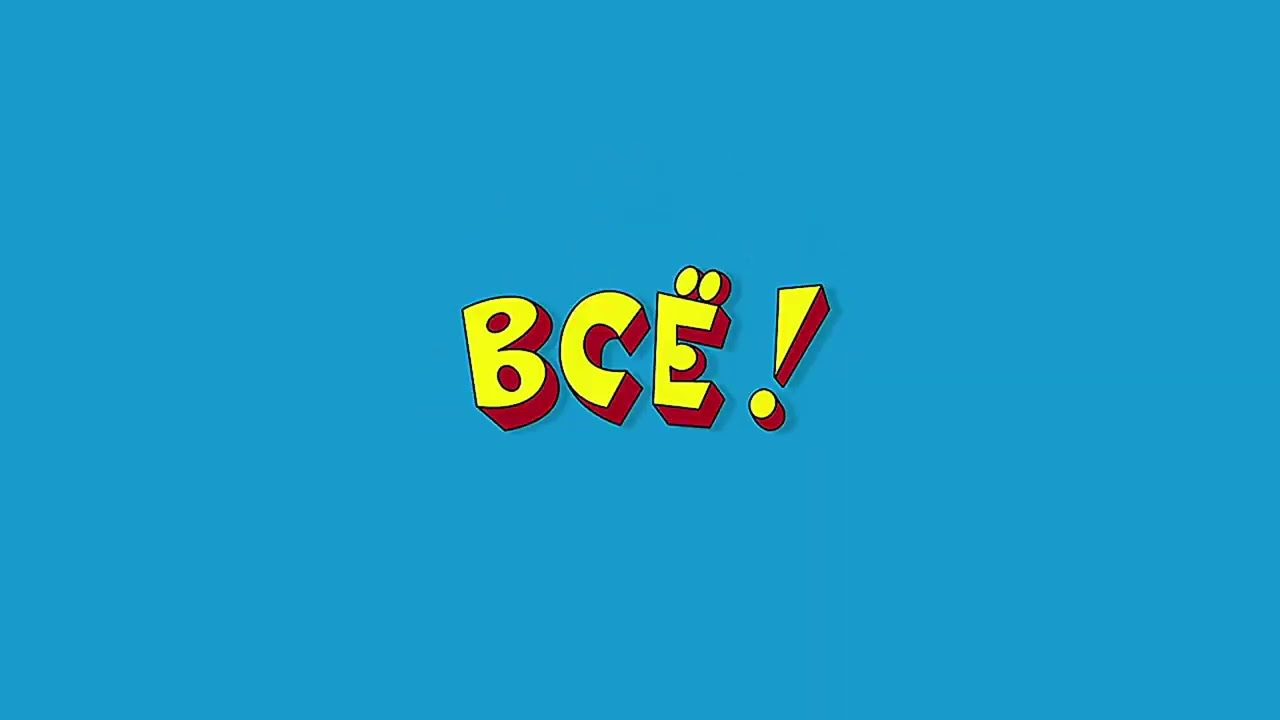